In [1]:
import os
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from diffusers import StableDiffusionPipeline
from diffusers.schedulers import LMSDiscreteScheduler

In [2]:
class DiffusionUtils:
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", safety_checker = None)
    pipe.to("cuda")
    pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
    orig_embeddings = pipe.text_encoder.text_model.embeddings.token_embedding.weight.clone().detach()
    pipe.text_encoder.text_model.embeddings.token_embedding.weight.requires_grad_(False)
    new_token = {}

    @classmethod
    def run_prompt(cls, prompt, num_images_per_seed, seed=0):
        with torch.no_grad():
            torch.manual_seed(seed)
            images = cls.pipe(prompt=[prompt] * num_images_per_seed, num_inference_steps=25, guidance_scale=7.5).images
            np_images = np.hstack([np.asarray(img) for img in images])
            plt.figure(figsize=(10,10))
            plt.imshow(np_images)
            plt.axis("off")
            plt.title(prompt)
            plt.show()

    @classmethod
    def add_new_vocab(cls, placeholder_token, embeddings):
        cls.pipe.tokenizer.add_tokens(placeholder_token)
        placeholder_token_id = cls.pipe.tokenizer.convert_tokens_to_ids(placeholder_token)

        cls.pipe.text_encoder.resize_token_embeddings(len(cls.pipe.tokenizer))
        token_embeds = cls.pipe.text_encoder.get_input_embeddings().weight.detach().requires_grad_(False)

        token_embeds[placeholder_token_id] = torch.nn.Parameter(embeddings)
        cls.new_token[placeholder_token] = placeholder_token_id
        print("New token added: ", placeholder_token)
        print("Current vocab size: ", len(cls.pipe.tokenizer))
        print("All new tokens: ", cls.new_token)


    @classmethod
    def reset_vocab(cls):
        cls.pipe.tokenizer = cls.pipe.tokenizer.__class__.from_pretrained(cls.pipe.tokenizer.name_or_path)
        cls.pipe.text_encoder.text_model.embeddings.token_embedding.weight.data = cls.orig_embeddings.clone().detach()
        cls.new_token.clear()
        
        print("Vocabulary has been reset.")
        print("Current vocab size: ", len(cls.pipe.tokenizer))

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

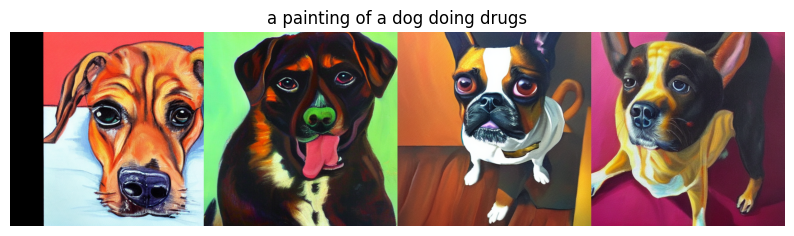

In [3]:
DiffusionUtils.run_prompt("a painting of a dog doing drugs", 4, seed=0)

In [4]:
class ResultKeeper:
    def __init__(self, exp_path, concept, node, seed, step=None):
        self.exp_path = exp_path
        self.concept = concept
        self.node = node
        self.seed = seed
        self.step = step

        self.folder = os.path.join(exp_path, concept, node, node + "_seed" + str(seed))
        self.score_path = os.path.join(self.folder, f"consistency_test/seed{seed}_scores.bin")

        self.load_results()
    
    def load_results(self):
        with open(self.score_path, 'rb') as f:
            self.scores = torch.load(f)
        
        if not self.step:
            final_step = -1
            final_score = 0
            for k in self.scores:
                if self.scores[k]['final'] > final_score:
                    final_score = self.scores[k]['final']
                    final_step = k
            self.step = final_step

        self.load_alphas()
    
    def load_alphas(self):
        left_path = os.path.join(self.folder, "learned_alphas", f"{self.step}_alphas_left.pt")
        right_path = os.path.join(self.folder, "learned_alphas", f"{self.step}_alphas_right.pt")
        bias_left_path = os.path.join(self.folder, "learned_alphas", f"{self.step}_bias_left.pt")
        bias_right_path = os.path.join(self.folder, "learned_alphas", f"{self.step}_bias_right.pt")
        dict_path = os.path.join(self.folder, "dictionary.pt")

        if os.path.exists(left_path):
            print("Loading both alphas")
            self.alphas_left = torch.load(left_path).detach_().requires_grad_(False)
            self.alphas_right = torch.load(right_path).detach_().requires_grad_(False)
        else:
            print("Loading one alphas")
            left_right_path = os.path.join(self.folder, "learned_alphas", f"{self.step}_alphas.pt")
            self.alphas_left = torch.load(left_right_path).detach_().requires_grad_(False)
            self.alphas_right = torch.load(left_right_path).detach_().requires_grad_(False)

        if os.path.exists(bias_left_path):
            print("Loading both bias")
            self.bias_left = torch.load(bias_left_path)
            self.bias_right = torch.load(bias_right_path)
        else:
            bias_left_right_path = os.path.join(self.folder, "learned_alphas", f"{self.step}_bias.pt")
            if os.path.exists(bias_left_right_path):
                print("Loading one bias")
                self.bias_left = torch.load(bias_left_right_path)
                self.bias_right = torch.load(bias_left_right_path)
            else:
                print("No bias found")
                self.bias_left = None
                self.bias_right = None

        self.dictionary = torch.load(dict_path)

In [5]:
def show_similar_words(rkpr: ResultKeeper, alphas_to_used='left', num_indices = 10):
    alphas_dict = rkpr.alphas_left if alphas_to_used == 'left' else rkpr.alphas_right
    dictionary = rkpr.dictionary    
    
    sorted_alphas, sorted_indices = torch.sort(alphas_dict, descending=True)
    top_indices_orig_dict = [dictionary[i] for i in sorted_indices[:num_indices]]
    top_coefs = sorted_alphas[:num_indices].cpu().numpy()
    alpha_ids = [DiffusionUtils.pipe.tokenizer.decode(idx) for idx in top_indices_orig_dict]

    print("top coefficients: ", top_coefs)
    print("top tokens: ", alpha_ids)
    return top_coefs, alpha_ids


def add_embedding(rkpr: ResultKeeper, placeholder_token, alphas_to_used='left', num_tokens=5000):
    alphas_dict = rkpr.alphas_left if alphas_to_used == 'left' else rkpr.alphas_right
    bias = rkpr.bias_left if alphas_to_used == 'left' else rkpr.bias_right
    dictionary = rkpr.dictionary

    alphas = torch.zeros(DiffusionUtils.orig_embeddings.shape[0]).cuda()
    sorted_alphas, sorted_indices = torch.sort(alphas_dict.abs(), descending=True)
    top_word_idx = [dictionary[i] for i in sorted_indices[:num_tokens]]
    for i,index in enumerate(top_word_idx):
        alphas[index] = alphas_dict[sorted_indices[i]]

    # compute w^* and normalize its embedding
    learned_embedding = torch.matmul(alphas, DiffusionUtils.orig_embeddings).flatten()
    norms = [i.norm().item() for i in DiffusionUtils.orig_embeddings]
    avg_norm = np.mean(norms)
    learned_embedding /= learned_embedding.norm()
    learned_embedding *= avg_norm

    # add bias
    if bias is not None:
        learned_embedding += bias

    DiffusionUtils.add_new_vocab(placeholder_token, learned_embedding)

def add_bias(rkpr: ResultKeeper, placeholder_token, bias_to_used='left'):
    bias = rkpr.bias_left if bias_to_used == 'left' else rkpr.bias_right
    if bias is not None:
        DiffusionUtils.add_new_vocab(placeholder_token, bias)
    else:
        print("No bias to add")

In [92]:
exp_path = "experiments/20241222_conceptor_one_emb"
concept = "cat_sculpture"
node = "v0"
seed = 111

result_keeper = ResultKeeper(exp_path, concept, node, seed)

Loading one alphas
No bias found


In [93]:
_ = show_similar_words(result_keeper, alphas_to_used='left')
_ = show_similar_words(result_keeper, alphas_to_used='right')

top coefficients:  [1.7857796 1.7772254 1.7278366 1.685483  1.6824639 1.5722773 1.4738581
 1.449048  1.3401474 1.3326485]
top tokens:  ['kati', 'inari', 'uka', 'wu', 'poppins', 'umbrella', 'mug', 'diego', 'tula', 'fa']
top coefficients:  [1.7857796 1.7772254 1.7278366 1.685483  1.6824639 1.5722773 1.4738581
 1.449048  1.3401474 1.3326485]
top tokens:  ['kati', 'inari', 'uka', 'wu', 'poppins', 'umbrella', 'mug', 'diego', 'tula', 'fa']


In [67]:
# def plot_by_score(data, title='Coefficients'):
#     score, labels = data
#     plt.barh(labels[::-1], score[::-1])
#     plt.xlabel('Score')
#     plt.ylabel('Word')
#     plt.title(title)
#     plt.show()

# plot_by_score(show_similar_words(result_keeper, alphas_to_used='right'), title='Coefficients for <*>')

In [95]:
DiffusionUtils.reset_vocab()

Vocabulary has been reset.
Current vocab size:  49408


In [99]:
add_embedding(result_keeper, "<*>", alphas_to_used='left', num_tokens=5000)
add_embedding(result_keeper, "<&>", alphas_to_used='right', num_tokens=5000)

New token added:  <*>
Current vocab size:  49414
All new tokens:  {'<*>': 49408, '<&>': 49409, '<*>_c1': 49410, '<*>_c2': 49411, '<*>_all': 49412, '<*>_al': 49413}
New token added:  <&>
Current vocab size:  49414
All new tokens:  {'<*>': 49408, '<&>': 49409, '<*>_c1': 49410, '<*>_c2': 49411, '<*>_all': 49412, '<*>_al': 49413}


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


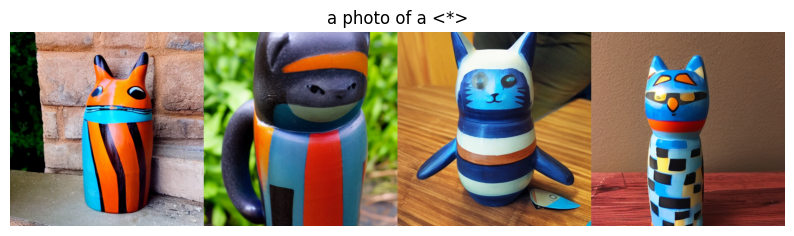

100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


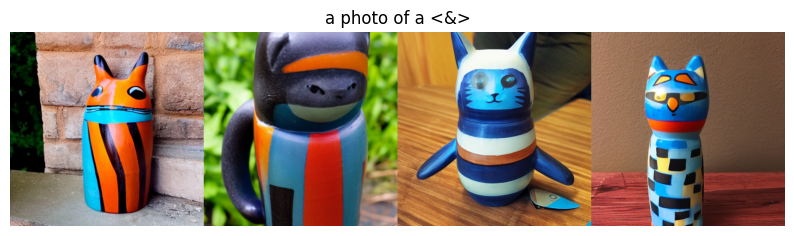

In [100]:
DiffusionUtils.run_prompt("a photo of a <*>", 4, seed=0)
DiffusionUtils.run_prompt("a photo of a <&>", 4, seed=0)

In [9]:
add_bias(result_keeper, "<*b>", bias_to_used='left')
add_bias(result_keeper, "<&b>", bias_to_used='right')

New token added:  <*b>
Current vocab size:  49411
All new tokens:  {'<*>': 49408, '<&>': 49409, '<*b>': 49410}
New token added:  <&b>
Current vocab size:  49412
All new tokens:  {'<*>': 49408, '<&>': 49409, '<*b>': 49410, '<&b>': 49411}


In [48]:
# DiffusionUtils.run_prompt("a photo of a <*>", 4, seed=0)
# DiffusionUtils.run_prompt("a photo of a <&>", 4, seed=0)
# DiffusionUtils.run_prompt("a photo of a <*b>", 4, seed=0)
# DiffusionUtils.run_prompt("a photo of a <&b>", 4, seed=0)

In [97]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

dict_embed = DiffusionUtils.orig_embeddings[result_keeper.dictionary]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(dict_embed.cpu())

# Get the cluster assignments
clusters = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Print results
print(f"Cluster assignments (first 10 examples): {clusters[:10]}")
print(f"Cluster centers shape: {cluster_centers.shape}")
print(f"Cluster Ratio: {np.sum(clusters) / len(clusters)}")


Cluster assignments (first 10 examples): [1 1 1 1 0 1 0 0 1 0]
Cluster centers shape: (2, 768)
Cluster Ratio: 0.7318


torch.Size([5000, 768])
torch.Size([1, 5000])
torch.Size([1, 5000])
Left: torch.Size([1, 768])
Right: torch.Size([1, 768])
New token added:  <*>_c1
Current vocab size:  49414
All new tokens:  {'<*>': 49408, '<&>': 49409, '<*>_c1': 49410, '<*>_c2': 49411, '<*>_all': 49412, '<*>_al': 49413}
New token added:  <*>_c2
Current vocab size:  49414
All new tokens:  {'<*>': 49408, '<&>': 49409, '<*>_c1': 49410, '<*>_c2': 49411, '<*>_all': 49412, '<*>_al': 49413}
New token added:  <*>_all
Current vocab size:  49414
All new tokens:  {'<*>': 49408, '<&>': 49409, '<*>_c1': 49410, '<*>_c2': 49411, '<*>_all': 49412, '<*>_al': 49413}


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


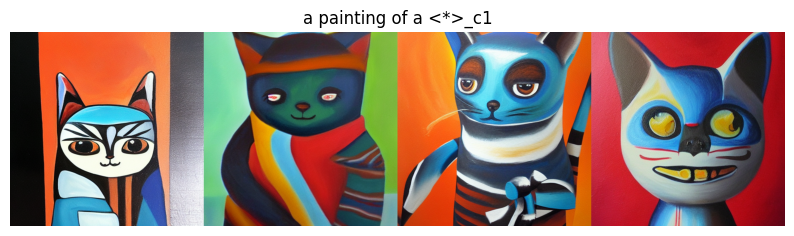

100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


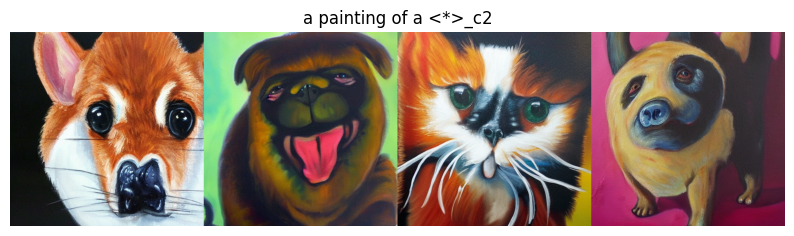

100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


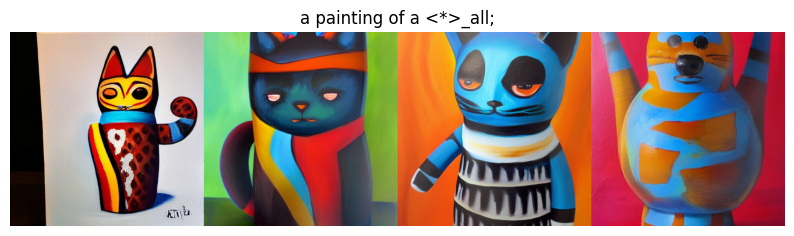

In [ ]:
# ctr1 = torch.tensor(cluster_centers[0], dtype=torch.float32)
# ctr2 = torch.tensor(cluster_centers[1], dtype=torch.float32)

alphas = result_keeper.alphas_left.unsqueeze(0)
clusters_tensor = torch.from_numpy(clusters).cuda().unsqueeze(0)

print(dict_embed.shape)
print(alphas.shape)
print(clusters_tensor.shape)

left = torch.matmul(alphas * clusters_tensor, dict_embed)
right = torch.matmul(alphas * (1 - clusters_tensor), dict_embed)
all = torch.matmul(alphas, dict_embed)

norms = [i.norm().item() for i in DiffusionUtils.orig_embeddings]
avg_norm = np.mean(norms)

left /= left.norm()
left *= avg_norm
right /= right.norm()
right *= avg_norm
all /= all.norm()
all *= avg_norm

print("Left:", left.shape)
print("Right:", right.shape)

DiffusionUtils.add_new_vocab("<*>_c1", left)
DiffusionUtils.add_new_vocab("<*>_c2", right)
DiffusionUtils.add_new_vocab("<*>_all", all)
DiffusionUtils.run_prompt("a painting of a <*>_c1", 4, seed=0)
DiffusionUtils.run_prompt("a painting of a <*>_c2", 4, seed=0)
DiffusionUtils.run_prompt("a painting of a <*>_all;", 4, seed=0)

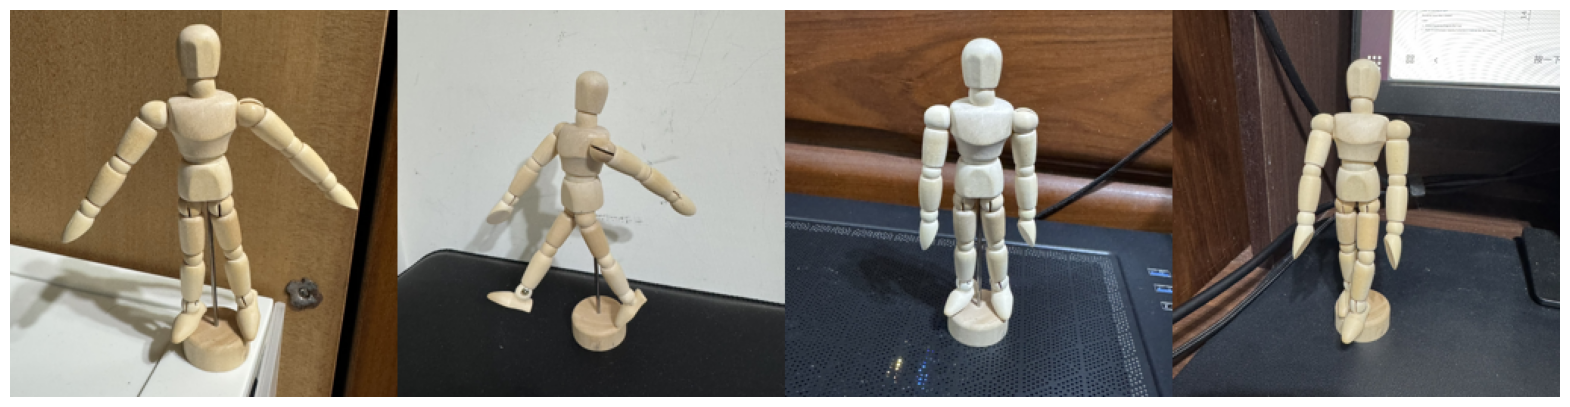

In [14]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

path = "/home/jack/Code/Research/instree_analysis/experiment_data/v1/wooden_puppet/v0"

img_list = []
for i in os.listdir(path):
    # read all image and show them together
    img = Image.open(os.path.join(path, i))
    # resize to same height
    img = img.resize((img.width * 256 // img.height, 256))
    img_list.append(img)


plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(np.hstack([np.asarray(img) for img in img_list]))